# Gradient Boosting Notes

### Core Idea

* Gradient Boosting builds a **strong model** by combining many **weak models** (often shallow decision trees).
* **Prediction** is the **sum of many small, not-too-complex predictions**:

```
ŷ = f1(x) + f2(x) + ... + fM(x)
```

* Each new model corrects the mistakes of the previous models.
* Think of it like: *“Each tree is a student trying to fix the errors of all previous students.”*

---

## Step 0: Define the Loss Function

* Gradient boosting is driven by a **loss function**, L(y, ŷ), which measures how wrong your predictions are.
* **It needs to be differentiable** because the algorithm uses **gradients** (derivatives) to decide how to improve the model.

**Why differentiable?**

* The gradient tells us the **direction and magnitude** to adjust our predictions to reduce error.
* Common examples:

  * Regression → Mean Squared Error (MSE)
  * Classification → Log Loss (cross-entropy)

---

## Step 1: Start with an Extremely Weak Learner

* Begin with a simple model f1(x) that is **very basic**, often just the mean of the target variable:

```
f1(x) = mean(y)
```

* Compute **residuals**, i.e., what the first prediction got wrong.
* This sets a baseline for the next learner to improve upon.

---

## Step 2: Compute the Gradients

* Key idea: Each subsequent learner predicts the **gradient of the loss with respect to current predictions**.

```
r1i = -∂L(yi, ŷi) / ∂ŷi
```

* These r\_i values are stored for all data points.

### What is a Gradient?

* Gradient = slope of the loss function with respect to predictions.
* Tells us:

  > “Which way and how much should we adjust our prediction for each data point to reduce the error?”
* Think of it like a **hill** — the gradient points **downhill toward lower loss**.

---

## Step 3: Fit the New Weak Learner

* Train a new weak learner f2(x) to **predict the gradient values** r1i.
* The new tree is trying to correct the mistakes of the previous prediction in the **direction that reduces the loss**.

---

## Step 4: Find the Optimal Weight to Add (Line Search)

* Add the new model with a scaling factor γ:

```
ŷ_new = ŷ_old + γ * f2(x)
```

* **Line search**: choose γ that **minimizes the loss** along this direction.

  * Like walking downhill: gradient = direction, line search = how far to step.
* In regression with MSE, γ can often be computed **analytically**.

---

## Step 5: Update the Model

* The new model is now:

```
F2(x) = F1(x) + γ1 * f2(x)
```

* Return to **Step 2**: recompute residuals/gradients based on the updated model.
* Repeat for **M iterations**, building one tree at a time.

---

## Why This Works

* Gradient boosting is essentially **gradient descent in function space**:

```
New model = Previous model + Small step in direction of decreasing loss
```

* Each new weak learner moves the overall prediction **slightly downhill** on the loss surface.
* Combining many small corrections results in a **strong predictive model**.
* **Learning rate** controls step size: smaller = slower but better generalization.

---

## Intuition Recap

1. Start with a naive guess (mean of target).
2. Find where it’s wrong (compute gradients/residuals).
3. Train a weak learner to fix those errors.
4. Decide how much of that learner to add (line search / learning rate).
5. Update prediction and repeat.
6. After many iterations, all small corrections sum up to a **strong model**.

---

## Extra Notes

* Works for **regression** (MSE loss) and **classification** (log loss).
* Hyperparameters to tune:

  * `n_estimators` → number of trees
  * `learning_rate` → step size for each tree
  * `max_depth` → complexity of each tree (shallow trees are weak learners)
  * `subsample` → fraction of data per tree (stochastic boosting)


In [1]:
from sklearn import datasets 
data = datasets.load_diabetes() 

In [2]:
import pandas as pd 
df = pd.DataFrame(data.data, columns=data.feature_names) 
df['target'] = pd.Series(data.target) 

In [3]:
df 

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


In [4]:
import numpy as np 

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt 

In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [7]:
df[df.duplicated()]

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target


In [8]:
y = df['target'] 
X = df.drop('target', axis=1)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=500)

gbr.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [11]:
y_pred = gbr.predict(X_test)

In [12]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_pred, y_test)
print(mae)

52.05025683296583


In [13]:
feature_scores = pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

s5     0.385029
bmi    0.213382
bp     0.092357
s2     0.078161
s6     0.054307
s3     0.053255
age    0.046092
s1     0.043086
s4     0.018138
sex    0.016193
dtype: float64


Text(0, 0.5, 'Features')

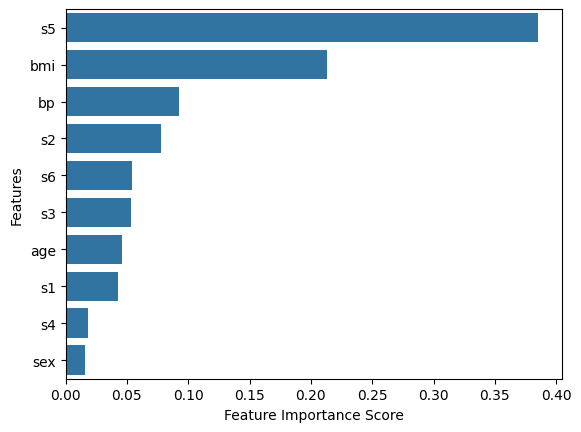

In [14]:
sns.barplot(x = feature_scores, y = feature_scores.index) 
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')